In [36]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


Upload the images

In [37]:

def load_images_from_csv(csv_path, base_path):
    # Load CSV file
    data = pd.read_csv(csv_path)
    
    # Filter data for labels A, B, C, D, E
    labels_of_interest = ['A', 'B', 'C', 'D', 'E']
    filtered_data = data[data['label'].isin(labels_of_interest)]
    
    # Prepare to load images
    images = []
    labels = []
    
    # Loop over filtered data to load images
    for _, row in filtered_data.iterrows():
        image_path = os.path.join(base_path, row['image'].replace("/", "\\"))
        if os.path.exists(image_path):  # Check if the file exists
            image = Image.open(image_path).convert('L')  # Open and convert to grayscale
            images.append(np.array(image))  # Append image array to list
            labels.append(row['label'])  # Append label
        else:
            print(f"Warning: Image not found at {image_path}")
    
    return images, labels


In [38]:
# Specify paths
csv_path = r'data\english.csv'
base_path = r'data'

# Load images and labels
images, labels = load_images_from_csv(csv_path, base_path)

print(f"Loaded {len(images)} images.")


Loaded 275 images.


In [39]:
list(set(labels))

['B', 'C', 'E', 'D', 'A']

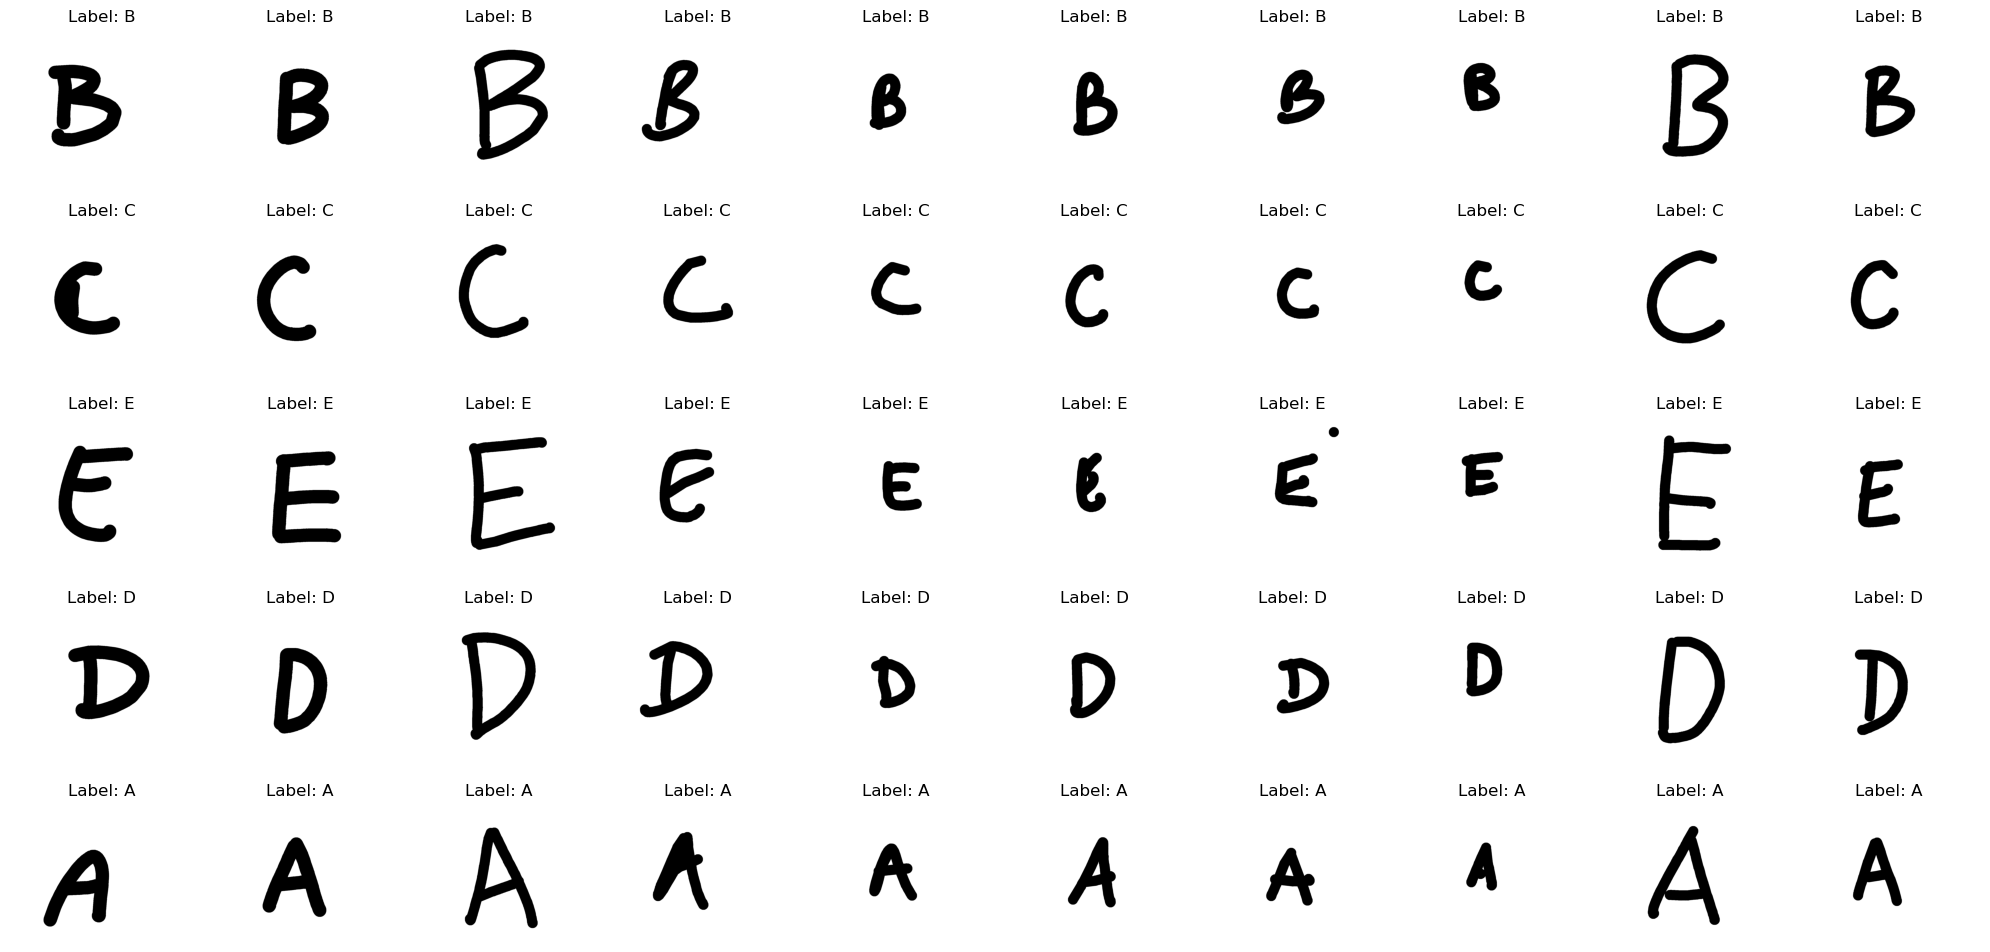

In [40]:
def display_images_by_label(images, labels):
    # Unique labels of interest
    # unique_labels = ['A', 'B', 'C', 'D', 'E']
    unique_labels = list(set(labels))
    
    # Set up the figure with a grid: 5 rows (for labels) and 10 columns (for images)
    fig, axes = plt.subplots(nrows=len(unique_labels), ncols=10, figsize=(20, 10))
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Create a counter for axes to ensure each subplot is filled correctly
    ax_counter = 0
    
    # Iterate over each label
    for label in unique_labels:
        # Filter images by current label
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        
        # Display the first 10 images of this label
        for image in label_images[:10]:
            axes[ax_counter].imshow(image, cmap='gray')
            axes[ax_counter].axis('off')
            axes[ax_counter].set_title(f'Label: {label}')
            ax_counter += 1
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_images_by_label(images, labels)


In [41]:
images[0].shape

(900, 1200)

Now we do the rescaling of the images

In [42]:
def resize_images(images, new_size=(40, 30)):  # Width = 40, Height = 30
    resized_images = []
    for img in images:
        # Convert array back to an Image object
        pil_image = Image.fromarray(img)
        # Resize image
        resized_image = pil_image.resize(new_size, Image.ANTIALIAS)
        # Convert resized image back to array and append to list
        resized_images.append(np.array(resized_image))
    return resized_images

# Resize all images
resized_images = resize_images(images)

# Print the shape of the first resized image to verify
print(f"Shape of the first resized image: {resized_images[0].shape}")


C:\Users\vikto\AppData\Local\Temp\ipykernel_33492\3427193575.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = pil_image.resize(new_size, Image.ANTIALIAS)


Shape of the first resized image: (30, 40)


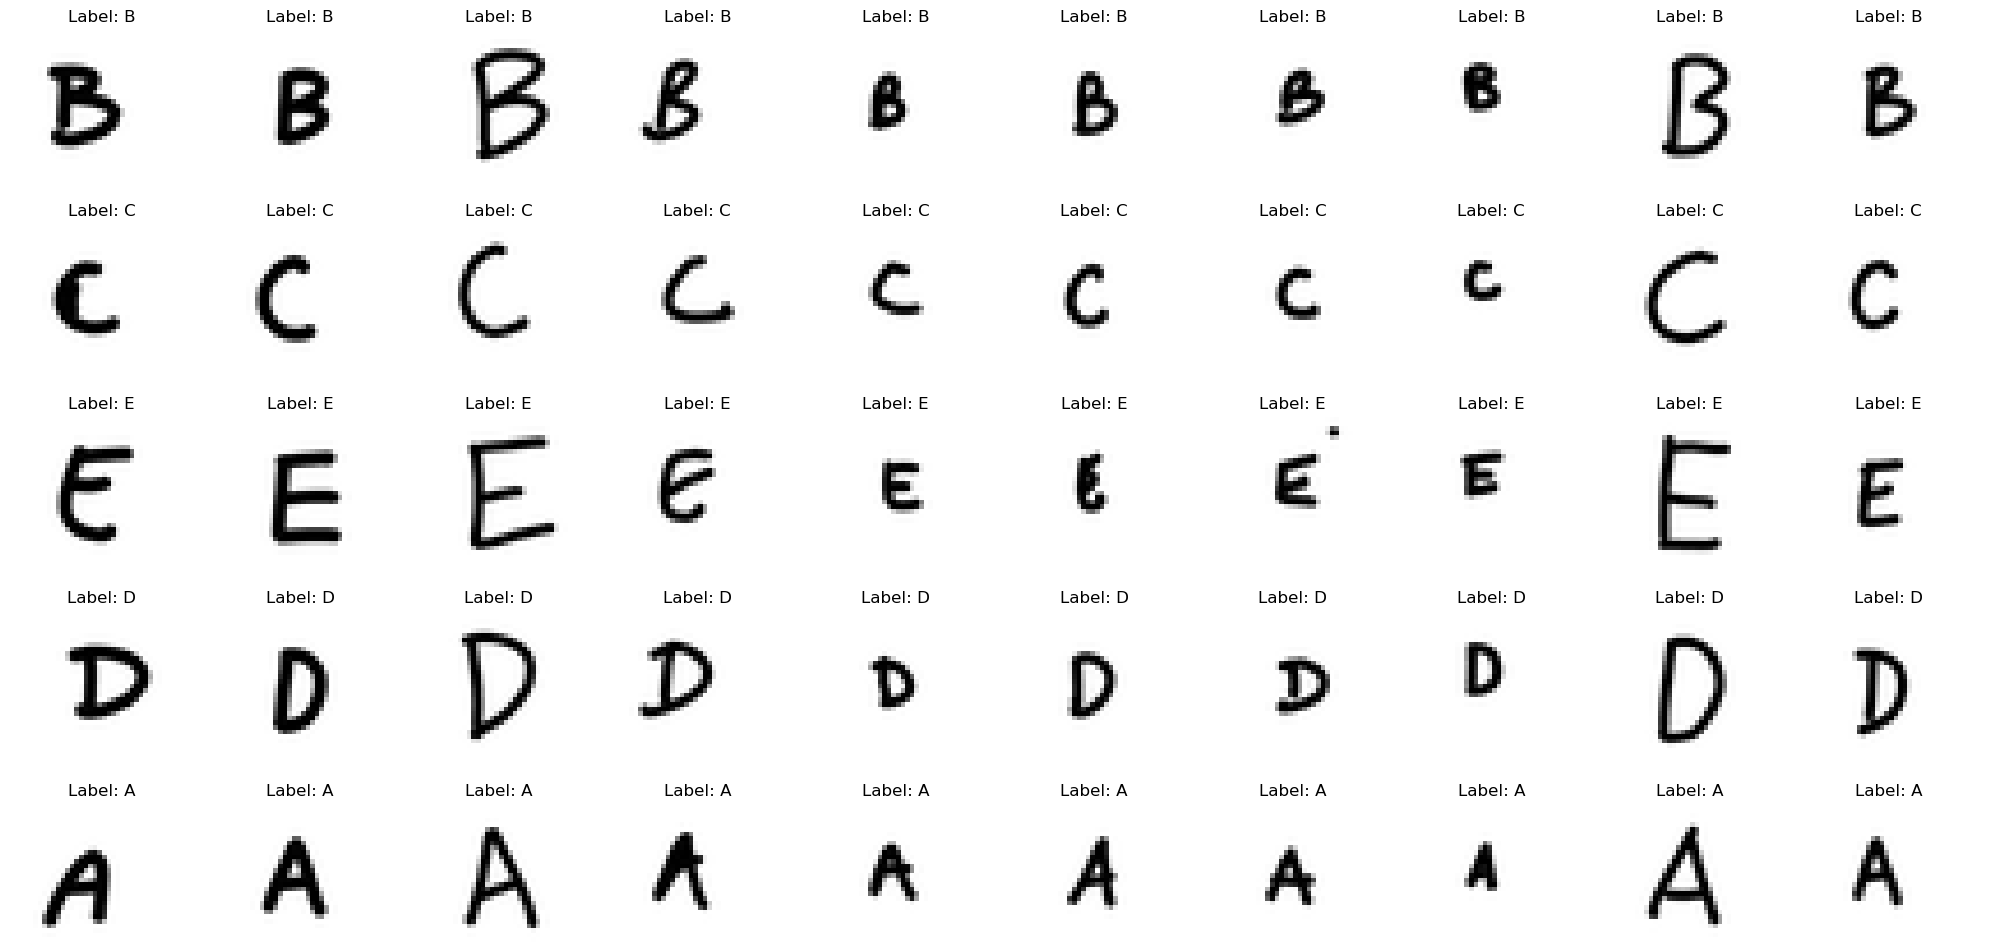

In [43]:
display_images_by_label(resized_images, labels)

In [44]:
type(resized_images[0]),resized_images[0].shape

(numpy.ndarray, (30, 40))

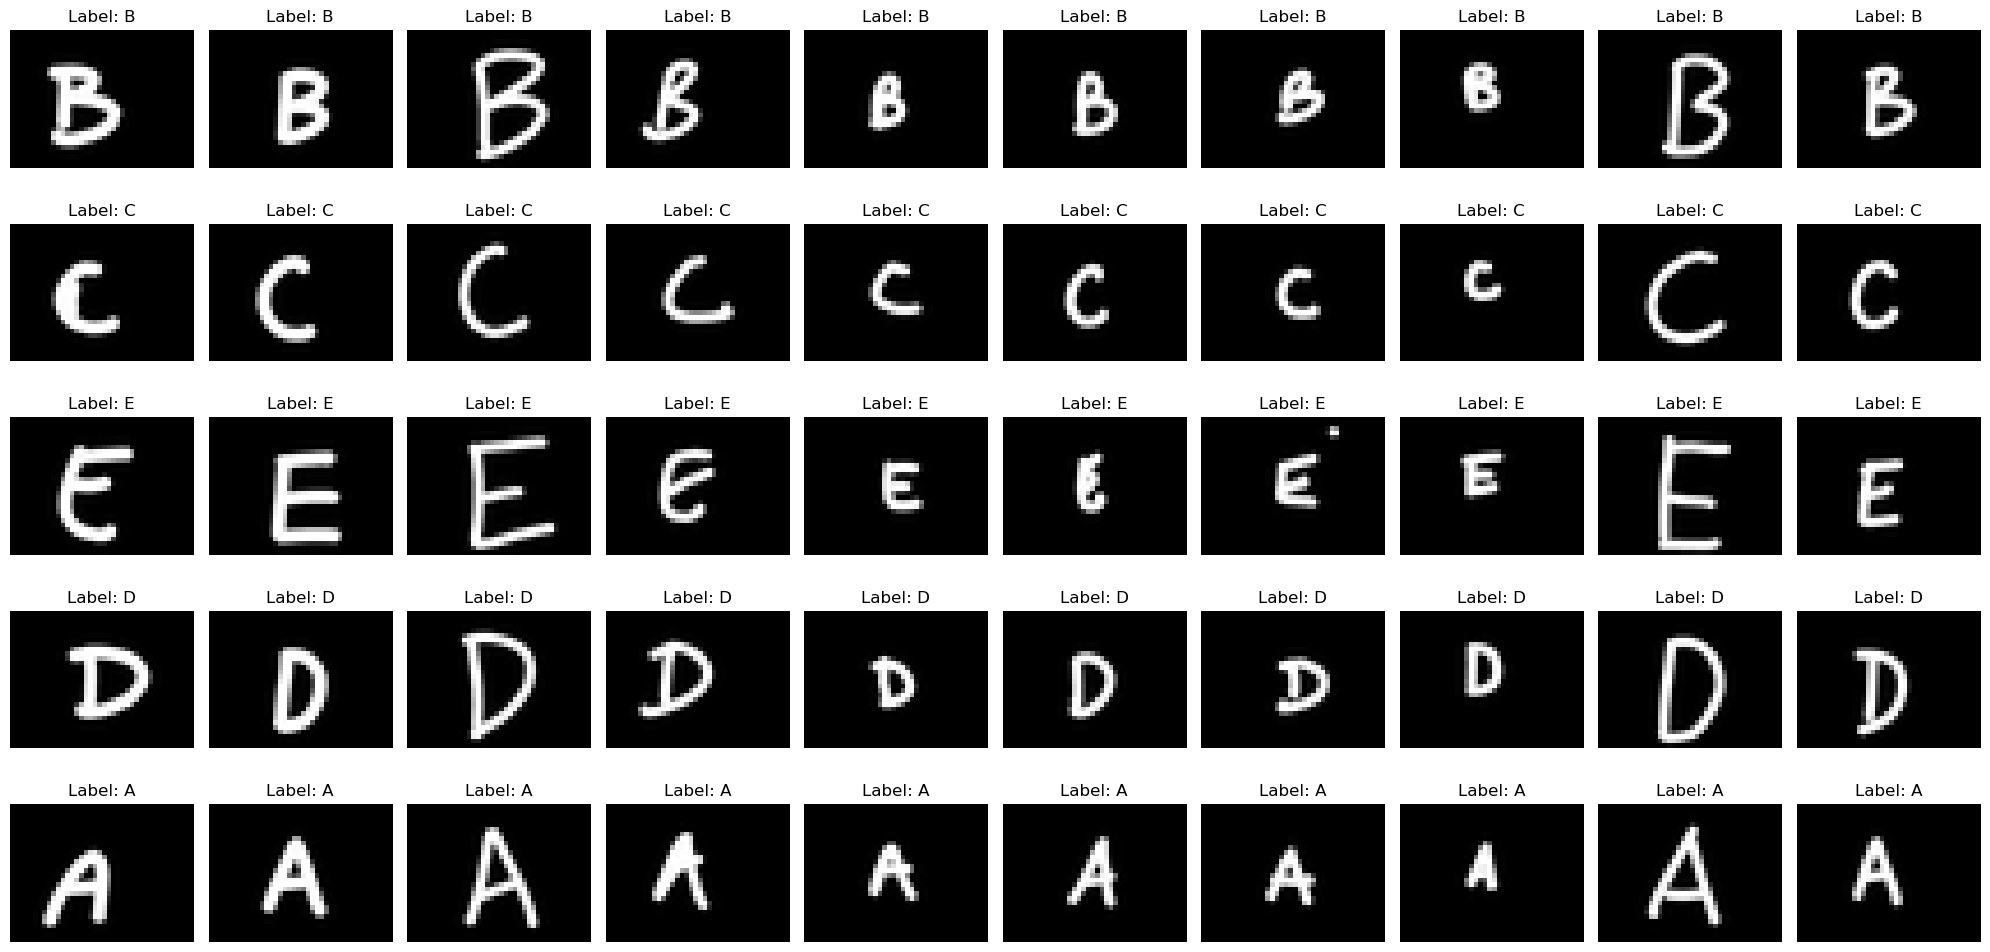

In [45]:
inverted_images = [255 - resized_image for resized_image in resized_images]
display_images_by_label(inverted_images, labels)

now, as you know, we have resized_images, which is a list of images, which are represented as (numpy.ndarray, (30, 40)). we also have labels which is a list of letters, position of which directly corresponds to the 

In [46]:
def flatten_and_normalize_images(images):
    # Flatten each image and normalize
    flattened_images = np.array([img.flatten() for img in images]) / 255.0
    return flattened_images

def one_hot_encode_labels(labels):
    # Map labels to indices (assuming 'A' to 'E')
    label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    indices = np.array([label_map[label] for label in labels])
    
    # One-hot encode indices
    num_classes = len(label_map)
    one_hot_encoded = np.zeros((indices.size, num_classes))
    one_hot_encoded[np.arange(indices.size), indices] = 1
    return one_hot_encoded

# Assuming 'resized_images' is your list of images and 'labels' is your list of labels
X = flatten_and_normalize_images(inverted_images)
y = one_hot_encode_labels(labels)

(array([0., 0., 0., ..., 0., 0., 0.]), 1200)

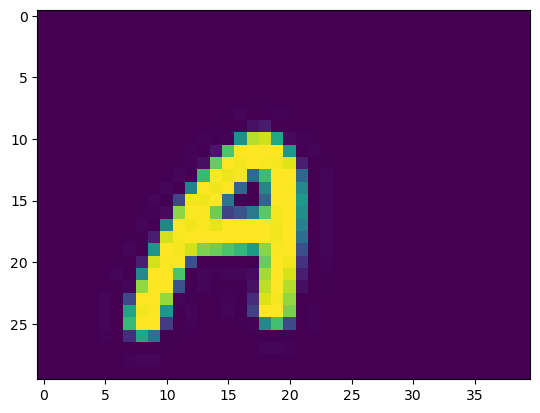

In [47]:
plt.imshow(inverted_images[0])
X[0], len(X[0])

In [48]:
y[0], len(y[0])

(array([1., 0., 0., 0., 0.]), 5)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
len(X_train)

220

In [50]:
def class_distribution(y):
    class_counts = np.sum(y, axis=0)
    total = np.sum(class_counts)
    distribution = (class_counts / total) * 100
    return distribution

train_distribution = class_distribution(y_train)
test_distribution = class_distribution(y_test)

print("Class distribution in training set (%):", train_distribution)
print("Class distribution in test set (%):", test_distribution)

approx_equal = np.isclose(train_distribution, test_distribution, atol=5)  # 5% tolerance
print("Are distributions approximately equal (within 5% tolerance)?:", approx_equal)


Class distribution in training set (%): [20.         20.45454545 19.54545455 19.54545455 20.45454545]
Class distribution in test set (%): [20.         18.18181818 21.81818182 21.81818182 18.18181818]
Are distributions approximately equal (within 5% tolerance)?: [ True  True  True  True  True]


Accuracy: 54.54545454545454 %


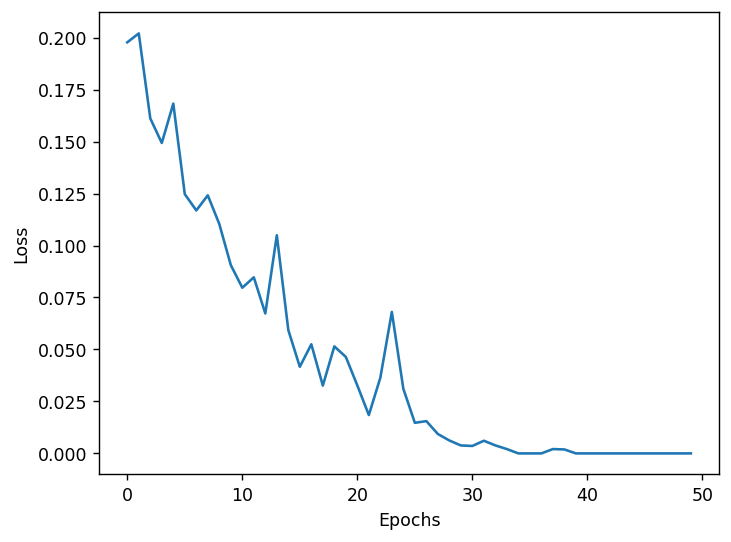

In [57]:
class NeuralNetwork:
    def __init__(self, X, y, batch = 64, lr = 1e-2,  epochs = 50):
        self.input = X 
        self.target = y
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        
        self.x = self.input[:self.batch] # batch input 
        self.y = self.target[:self.batch] # batch target value
        self.loss = []
        self.acc = []
        
        self.init_weights()
      
    def init_weights(self):
        self.W1 = np.random.randn(self.input.shape[1],128)
        self.W2 = np.random.randn(self.W1.shape[1],64)
        self.W3 = np.random.randn(self.W2.shape[1],self.y.shape[1])

        self.b1 = np.random.randn(self.W1.shape[1],)
        self.b2 = np.random.randn(self.W2.shape[1],)
        self.b3 = np.random.randn(self.W3.shape[1],)

    def ReLU(self, x):
        return np.maximum(0,x)

    def dReLU(self,x):
        return 1 * (x > 0) 
    
    def softmax(self, z):
        z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
        return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)
    
    def shuffle(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.target = self.target[idx]
        
    def feedforward(self):
        assert self.x.shape[1] == self.W1.shape[0]
        self.z1 = self.x.dot(self.W1) + self.b1
        self.a1 = self.ReLU(self.z1)

        assert self.a1.shape[1] == self.W2.shape[0]
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.ReLU(self.z2)

        assert self.a2.shape[1] == self.W3.shape[0]
        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        self.error = self.a3 - self.y

        
    def backprop(self):
        dcost = (1/self.batch)*self.error
        
        DW3 = np.dot(dcost.T,self.a2).T
        DW2 = np.dot((np.dot((dcost),self.W3.T) * self.dReLU(self.z2)).T,self.a1).T
        DW1 = np.dot((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)).T,self.x).T

        db3 = np.sum(dcost,axis = 0)
        db2 = np.sum(np.dot((dcost),self.W3.T) * self.dReLU(self.z2),axis = 0)
        db1 = np.sum((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)),axis = 0)
        
        assert DW3.shape == self.W3.shape
        assert DW2.shape == self.W2.shape
        assert DW1.shape == self.W1.shape
        
        assert db3.shape == self.b3.shape
        assert db2.shape == self.b2.shape
        assert db1.shape == self.b1.shape 
        
        self.W3 = self.W3 - self.lr * DW3
        self.W2 = self.W2 - self.lr * DW2
        self.W1 = self.W1 - self.lr * DW1
        
        self.b3 = self.b3 - self.lr * db3
        self.b2 = self.b2 - self.lr * db2
        self.b1 = self.b1 - self.lr * db1

    def train(self):
        for epoch in range(self.epochs):
            l = 0
            acc = 0
            self.shuffle()
            
            for batch in range(self.input.shape[0]//self.batch-1):
                start = batch*self.batch
                end = (batch+1)*self.batch
                self.x = self.input[start:end]
                self.y = self.target[start:end]
                self.feedforward()
                self.backprop()
                l+=np.mean(self.error**2)
                acc+= np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.batch
                
            self.loss.append(l/(self.input.shape[0]//self.batch))
            self.acc.append(acc*100/(self.input.shape[0]//self.batch))
            
    def plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        
    def test(self,xtest,ytest):
        self.x = xtest
        self.y = ytest
        self.feedforward()
        acc = np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.x.shape[0]
        print("Accuracy:", 100 * acc, "%")
    
    
    # code to test the result with a single example
    def predict(self, x):
        """ Predict the class of a single sample """
        self.x = x.reshape(1, -1)  # Reshape x to ensure it's 2D (1 sample, many features)
        self.feedforward()
        return np.argmax(self.a3, axis=1)  # Return the index of the highest probability

    def test_single_example(self, xtest, ytest):
        prediction = self.predict(xtest)
        actual_label = np.argmax(ytest)
        print(f"Predicted Label: {prediction[0]}")
        print(f"Actual Label: {actual_label}")
        print(f"Correct: {prediction[0] == actual_label}")

        
        
NN = NeuralNetwork(X_train, y_train) 
NN.train()
NN.plot()
NN.test(X_test,y_test)


Predicted Label: 0
Actual Label: 0
Correct: True


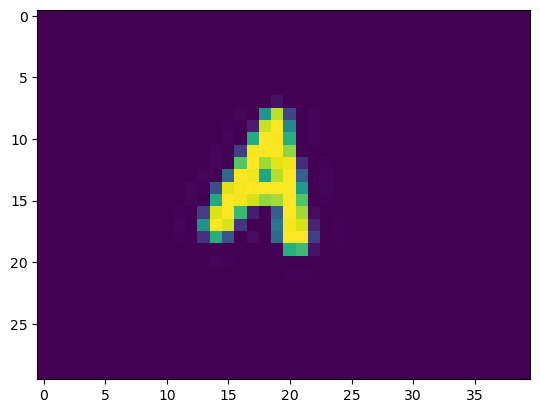

In [61]:
plt.imshow(X_test[0].reshape(30,40))
NN.test_single_example(X_test[0], y_test[0])